In [14]:
# imports
import math
from math import log2
import random
import numpy as np
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms.functional as fn
from tqdm import tqdm

# hyperparameters
batch_size  = 32 #BATCH_SIZES
n_channels  = 3 #CHANNELS_IMG
latent_size = 512
dataset = 'cifar10'
START_TRAIN_AT_IMG_SIZE = 32 # IF WE START AT 4, ENSURE THE SIZE OF FAKE IS ALSO THE SAME [as 128/4 = 32]
LEARNING_RATE           = 1e-3
BATCH_SIZES             = [32, 32, 32, 16, 16, 16, 16, 8, 4]
image_size              = 128
Z_DIM                   = 256  
IN_CHANNELS             = 256  
CRITIC_ITERATIONS       = 1
LAMBDA_GP               = 10
PROGRESSIVE_EPOCHS      = [10] * len(BATCH_SIZES)

# Set torch to use the GPU if it is avaliable
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') #DEVICE

FIXED_NOISE             = torch.randn(8, Z_DIM, 1, 1).to(device)

In [2]:
# optional for Colab use only - Google drive integration - this will allow you to save and resume training, and may speed up redownloading the dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# helper function to make getting another batch of data easier
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

# Define the class names
class_names = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Load the cifar10 and stl10 datasets to check the images
if dataset == 'cifar10':
    data_view = torchvision.datasets.CIFAR10('drive/My Drive/training/cifar10', train=True, download=True, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),]))
    # Select the cat class and create the subset
    idx = torch.tensor(data_view.targets) == class_names.index("cat")
    train_dataset_view = torch.utils.data.dataset.Subset(data_view, np.where(idx == 1)[0])
    train_loader_view = torch.utils.data.DataLoader(train_dataset_view,
        shuffle=True, batch_size=batch_size, num_workers = 4, drop_last=True
    )

    # Define the test sets perhaps

# # stl10 has larger images which are much slower to train on. You should develop your method with CIFAR-10 before experimenting with STL-10
# if dataset == 'stl10':
#     train_loader = torch.utils.data.DataLoader(
#         torchvision.datasets.STL10('drive/My Drive/training/stl10', split='train+unlabeled', download=True, transform=torchvision.transforms.Compose([
#             torchvision.transforms.ToTensor(),
#         ])),
#     shuffle=True, batch_size=batch_size, drop_last=True)
#     train_iterator = iter(cycle(train_loader))
#     class_names = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck'] # these are slightly different to CIFAR-10

# train_iterator = iter(cycle(train_loader))

# For latter processing (of cifar10)
def get_loader(image_size):
    transform = torchvision.transforms.Compose(
        [
            torchvision.transforms.Resize((image_size, image_size)),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.RandomHorizontalFlip(p=0.5),
            torchvision.transforms.Normalize(
                [0.5 for _ in range(n_channels)],
                [0.5 for _ in range(n_channels)],
            ),
        ]
    )
    batch_size = BATCH_SIZES[int(log2(image_size / 4))]
    data = torchvision.datasets.CIFAR10('drive/My Drive/training/cifar10', train=True, download=True, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),]))
    # Select the cat class and create the subset
    idx = torch.tensor(data.targets) == class_names.index("cat")
    train_dataset = torch.utils.data.dataset.Subset(data, np.where(idx == 1)[0])
    train_loader = torch.utils.data.DataLoader(train_dataset,
        shuffle=True, batch_size=batch_size, num_workers = 4, drop_last=True
    )
    return train_loader, train_dataset

Files already downloaded and verified


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified


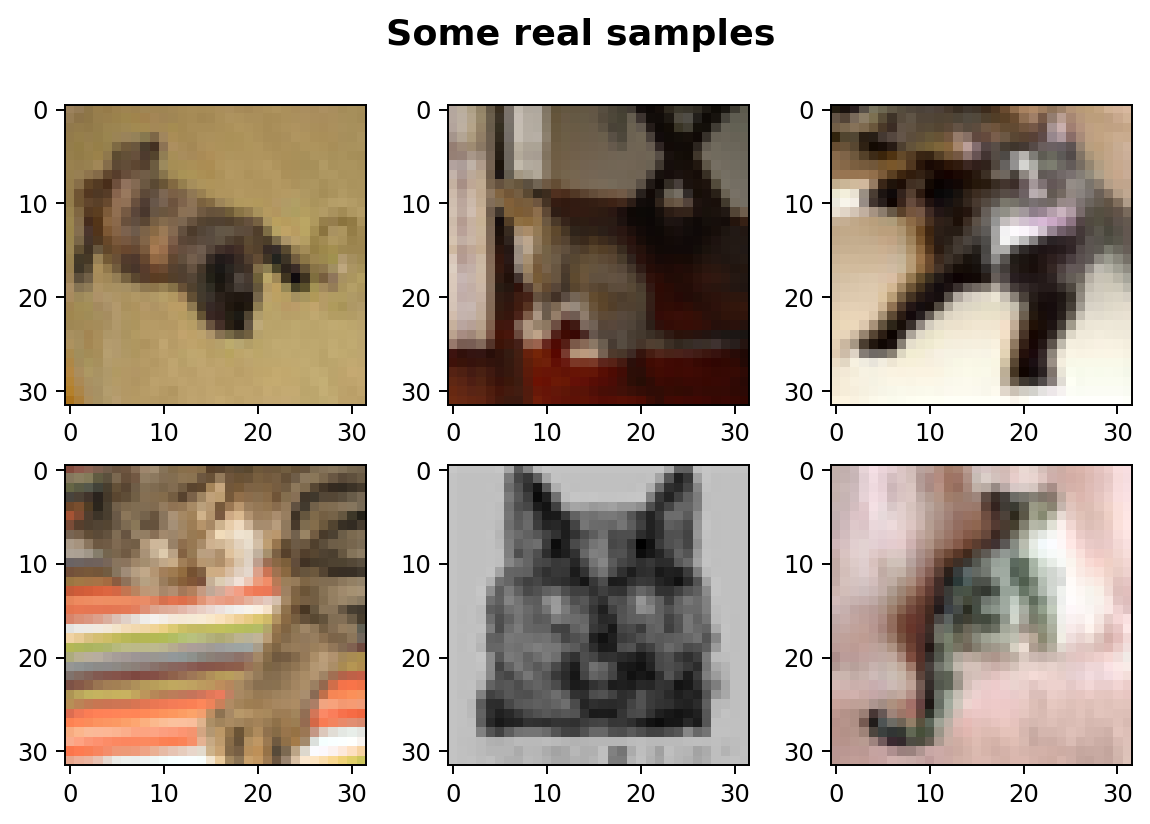

In [20]:
def check_loader():
    train_loader,_ = get_loader(128)
    cloth ,_ = next(iter(train_loader))
    _, ax = plt.subplots(2,3, figsize=(8,5))
    plt.suptitle('Some real samples', fontsize=15, fontweight='bold')
    ind = 0 
    for k in range(2):
        for kk in range(3):
            
            ax[k][kk].imshow((cloth[ind].permute(1,2,0)) )
            ind += 1
check_loader()

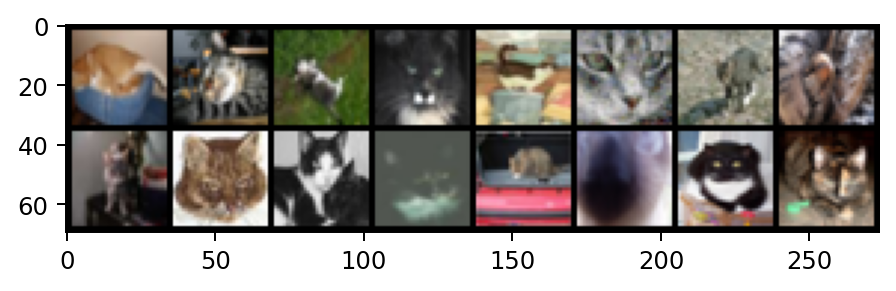

In [5]:
# View some of the training data images
plt.rcParams['figure.dpi'] = 175
x,t = next(iter(cycle(train_loader_view)))
x,t = x.to(device), t.to(device)
plt.grid(False)
plt.imshow(torchvision.utils.make_grid(x).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
plt.show()


In [23]:
channels = 3
# The images are 128x128 size
width = 128
factors = [1, 1, 1, 1, 1/2, 1/4, 1/8, 1/16, 1/32] # See the generator output shape
# factors = [1, 1, 1, 1, 1, 1, 1 / 2, 1 / 4, 1 / 8, 1 / 16, 1 / 32, 1 / 64, 1 / 128]

# The weighted scale convolution layer
class WSConv2d(nn.Module):
    def __init__(
        self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, gain=2
    ):
        super(WSConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.scale = (gain / (in_channels * (kernel_size ** 2))) ** 0.5
        self.bias = self.conv.bias
        # We remove the bias
        self.conv.bias = None
        nn.init.normal_(self.conv.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        # Add the bias
        return self.conv(x * self.scale) + self.bias.view(1, self.bias.shape[0], 1, 1)

# Used in the generator
class PixelNorm(nn.Module):
    def __init__(self):
        super(PixelNorm, self).__init__()
        self.epsilon = 1e-8

    # Take the mean across the channels
    def forward(self, x):
        return x / torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True) + self.epsilon)

# Implement the 3x3 convolutional blocks
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_pixelnorm=True):
        super(ConvBlock, self).__init__()
        self.use_pn = use_pixelnorm
        self.conv1 = WSConv2d(in_channels, out_channels)
        self.conv2 = WSConv2d(out_channels, out_channels)
        self.leaky = nn.LeakyReLU(0.2)
        self.pn = PixelNorm()

    def forward(self, x):
        # Ensure there are two convolutional layers
        # And then leaky RELU and pixel norm, otherwise return x
        x = self.leaky(self.conv1(x))
        x = self.pn(x) if self.use_pn else x
        x = self.leaky(self.conv2(x))
        x = self.pn(x) if self.use_pn else x
        return x

# Define the generator
# class Generator(nn.Module):
#     def __init__(self, latent_size=100):
#         super(Generator, self).__init__()
#         self.initial = nn.Sequential(
#             PixelNorm(),
#             nn.ConvTranspose2d(z_dim, in_channels, 4, 1, 0),
#             nn.LeakyReLU(0.2),
#             WSConv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
#             nn.LeakyReLU(0.2),
#             PixelNorm(),
#         )
#     def forward(self, x):
#         x = self.layer(x)
#         x = x.view(x.size(0), channels, width, width)
#         return x

# # Define the discriminator 
# class Discriminator(nn.Module):
#     def __init__(self):
#         super(Discriminator, self).__init__()
#         self.layer = nn.Sequential(
#             nn.Linear(channels*width*width, 512),
#             nn.LeakyReLU(0.2),
#             nn.Linear(512, 256),
#             nn.LeakyReLU(0.2),
#             nn.Linear(256, 1), # 1 output for real/fake
#             nn.Sigmoid(),
#         )
#     def forward(self, x):
#         x = x.view(x.size(0), -1)
#         x = self.layer(x)
#         return x

class Generator(nn.Module):
    def __init__(self, z_dim, in_channels, img_channels=3):
        super(Generator, self).__init__()
        # Create the initial layer for the transpose convolution
        self.initial = nn.Sequential(
            PixelNorm(),
            # Turn the 1x1 pixel to 4x4
            nn.ConvTranspose2d(z_dim, in_channels, 4, 1, 0),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            PixelNorm(),
        )
        # Convert the initial black and white to RGB
        self.initial_rgb = WSConv2d(
            in_channels, img_channels, kernel_size=1, stride=1, padding=0
        )
        self.prog_blocks, self.rgb_layers = (
            nn.ModuleList([]),
            nn.ModuleList([self.initial_rgb]),
        )
        # Go through the factors to create the prog blocks
        for i in range(len(factors) - 1):  
            # To define how many channels we have, based on multiplying with our factors
            conv_in_c = int(in_channels * factors[i])
            conv_out_c = int(in_channels * factors[i + 1])
            self.prog_blocks.append(ConvBlock(conv_in_c, conv_out_c))
            self.rgb_layers.append(
                WSConv2d(conv_out_c, img_channels, kernel_size=1, stride=1, padding=0))
            
    def fade_in(self, alpha, upscaled, generated):
        # Ensure the output is between -1 and 1
        return torch.tanh(alpha * generated + (1 - alpha) * upscaled)
    
    def forward(self, x, alpha, steps):
        out = self.initial(x)
        # Return 4x4 when we are on step 0
        if steps == 0:
            return self.initial_rgb(out)
        # Double the size at each of the steps
        for step in range(steps):
            # Upscale and pass it through the progressive block for that resolution
            upscaled = F.interpolate(out, scale_factor=2, mode="nearest")
            out = self.prog_blocks[step](upscaled)
        # Make sure the RGB layer is behind one step allowing the same number of channels
        final_upscaled = self.rgb_layers[steps - 1](upscaled)
        final_out = self.rgb_layers[steps](out)
        return self.fade_in(alpha, final_upscaled, final_out)

class Discriminator(nn.Module):
    def __init__(self, z_dim, in_channels, img_channels=3):
        super(Discriminator, self).__init__()
        # Downsampling instead of upsampling
        self.prog_blocks, self.rgb_layers = nn.ModuleList([]), nn.ModuleList([])
        self.leaky = nn.LeakyReLU(0.2)
        # Go thorugh the factors in reverse
        for i in range(len(factors) - 1, 0, -1):
            conv_in = int(in_channels * factors[i])
            conv_out = int(in_channels * factors[i - 1])
            self.prog_blocks.append(ConvBlock(conv_in, conv_out, use_pixelnorm=False))
            self.rgb_layers.append(
                WSConv2d(img_channels, conv_in, kernel_size=1, stride=1, padding=0)
            )
        # The other way around due to the channels we require
        # For 4x4 resolution
        self.initial_rgb = WSConv2d(img_channels, in_channels, kernel_size=1, stride=1, padding=0)
        self.rgb_layers.append(self.initial_rgb)
        # The downsampling
        self.avg_pool = nn.AvgPool2d(kernel_size=2, stride=2)  
        self.final_block = nn.Sequential(
            WSConv2d(in_channels + 1, in_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=4, stride=1, padding=0),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, 1, kernel_size=1, stride=1, padding=0), 
        )

    def fade_in(self, alpha, downscaled, out):
        return alpha * out + (1 - alpha) * downscaled

    def minibatch_std(self, x):
        # Standard deviation across the channels, heights and widths
        batch_statistics = (torch.std(x, dim=0).mean().repeat(x.shape[0], 1, x.shape[2], x.shape[3]))
        return torch.cat([x, batch_statistics], dim=1)

    def forward(self, x, alpha, steps):
        cur_step = len(self.prog_blocks) - steps
        out = self.leaky(self.rgb_layers[cur_step](x))
        # For 4x4 when steps = 0
        if steps == 0:  
            # Concatenate and run through the final block
            out = self.minibatch_std(out)
            return self.final_block(out).view(out.shape[0], -1)
        # Fade in first in the discriminator
        downscaled = self.leaky(self.rgb_layers[cur_step + 1](self.avg_pool(x)))
        out = self.avg_pool(self.prog_blocks[cur_step](out))
        out = self.fade_in(alpha, downscaled, out)
        # Multiply by two for the other steps
        for step in range(cur_step + 1, len(self.prog_blocks)):
            out = self.prog_blocks[step](out)
            out = self.avg_pool(out)
        out = self.minibatch_std(out)
        return self.final_block(out).view(out.shape[0], -1)

# G = Generator(Z_DIM, IN_CHANNELS).to(device)
# D = Discriminator(Z_DIM, IN_CHANNELS).to(device)

# Initialise the optimiser
# optimiser_G = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
# optimiser_D = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Define the loss function
criterion = nn.BCELoss()
epoch = 0

In [7]:
def gradient_penalty(critic, real, fake, alpha, train_step, current_image_size, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    #real_new = fn.resize(real, size=[current_image_size])

    beta = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    #beta = fn.resize(real, size=[current_image_size])

    #fake = fn.resize(fake, size=[current_image_size])
    
    interpolated_images = real * beta + fake.detach() * (1 - beta)
    interpolated_images.requires_grad_(True)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images, alpha, train_step)
 
    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

In [8]:
# Examples saved to local device
def generate_examples(gen, steps, n=100):

    gen.eval()
    alpha = 1.0
    for i in range(n):
        with torch.no_grad():
            noise = torch.randn(1, Z_DIM, 1, 1).to(device)
            img = gen(noise, alpha, steps) 
            if not os.path.exists(f"drive/My Drive/saved_examples/step{steps}"):
                os.makedirs(f"drive/My Drive/saved_examples/step{steps}")
            torchvision.utils.save_image(img*0.5+0.5, f"drive/My Drive/saved_examples/step{steps}/img_{i}.png")
    gen.train()

In [9]:
# optional example code to save your training progress for resuming later
# torch.save({'G':G.state_dict(), 'D':D.state_dict(), 'optimiser_G':optimiser_G.state_dict(), 'optimiser_D':optimiser_D.state_dict(), 'FIXED_NOISE':FIXED_NOISE, 'epoch':epoch}, 'drive/My Drive/training/save2.chkpt')

# optional example to resume training later
# params = torch.load('drive/My Drive/training/save2.chkpt')
# G.load_state_dict(params['G'])
# D.load_state_dict(params['D'])
# optimiser_G.load_state_dict(params['optimiser_G'])
# optimiser_D.load_state_dict(params['optimiser_D'])
# FIXED_NOISE = params['FIXED_NOISE']
# epoch = params['epoch']

**Define a simple convolutional autoencoder**

In [10]:
# # simple block of convolution, batchnorm, and leakyrelu
# class Block(nn.Module):
#     def __init__(self, in_f, out_f):
#         super(Block, self).__init__()
#         self.f = nn.Sequential(
#             nn.Conv2d(in_f, out_f, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(out_f),
#             nn.LeakyReLU(inplace=True)
#         )
#     def forward(self,x):
#         return self.f(x)

# # define the model
# class Autoencoder(nn.Module):
#     def __init__(self, f=16):
#         super().__init__()

#         self.encode = nn.Sequential(
#             Block(n_channels, f),
#             nn.MaxPool2d(kernel_size=(2,2)), # output = 16x16 (if cifar10, 48x48 if stl10)
#             Block(f  ,f*2),
#             nn.MaxPool2d(kernel_size=(2,2)), # output = 8x8
#             Block(f*2,f*4),
#             nn.MaxPool2d(kernel_size=(2,2)), # output = 4x4
#             Block(f*4,f*4),
#             nn.MaxPool2d(kernel_size=(2,2)), # output = 2x2
#             Block(f*4,f*4),
#             nn.MaxPool2d(kernel_size=(2,2)), # output = 1x1
#             Block(f*4,latent_size),
#         )

#         self.decode = nn.Sequential(
#             nn.Upsample(scale_factor=2), # output = 2x2
#             Block(latent_size,f*4),
#             nn.Upsample(scale_factor=2), # output = 4x4
#             Block(f*4,f*4),
#             nn.Upsample(scale_factor=2), # output = 8x8
#             Block(f*4,f*2),
#             nn.Upsample(scale_factor=2), # output = 16x16
#             Block(f*2,f  ),
#             nn.Upsample(scale_factor=2), # output = 32x32
#             nn.Conv2d(f,n_channels, 3,1,1),
#             nn.Sigmoid()
#         )

# # Create the model and the optimiser
# A = Autoencoder().to(device)
# print(f'> Number of autoencoder parameters {len(torch.nn.utils.parameters_to_vector(A.parameters()))}')
# optimiser = torch.optim.Adam(A.parameters(), lr=0.001)
# epoch = 0

In [16]:
# ADD A METHOD TO KEEP RUNNING THE CODE #

def train_fn(
      critic,
      gen,
      train_loader,
      train_dataset,
      step,
      alpha,
      opt_critic,
      opt_gen,
      scaler_gen,
      scaler_critic,
      current_image_size,
):
    loop = tqdm(train_loader, leave=True)
    for batch_idx, (real, _) in enumerate(loop):
        real = real.to(device)
        cur_batch_size = real.shape[0]

        # Ensure the fake kernel keeps up with the real kernel

        noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(device)

        with torch.cuda.amp.autocast():
          fake = gen(noise, alpha, step)
          critic_real = critic(real, alpha, step)
          critic_fake = critic(fake.detach(), alpha, step)

        # Ensure the fake kernel keeps up with the real kernel

          gp = gradient_penalty(critic, real, fake, alpha, step, current_image_size, device=device)
          loss_critic = (
              -(torch.mean(critic_real) - torch.mean(critic_fake))
              + LAMBDA_GP * gp
              # Stop the critic going too far from the origin
              + (0.001 * torch.mean(critic_real ** 2))
          )

        opt_critic.zero_grad()
        scaler_critic.scale(loss_critic).backward()
        scaler_critic.step(opt_critic)
        scaler_critic.update()

        # critic.zero_grad()
        # loss_critic.backward()
        # opt_critic.step()
 
        # Train the generator
        gen_fake = critic(fake, alpha, step)
        loss_gen = -torch.mean(gen_fake)

        opt_gen.zero_grad()
        scaler_gen.scale(loss_gen).backward()
        scaler_gen.step(opt_gen)
        scaler_gen.update()          

        # gen.zero_grad()
        # loss_gen.backward()
        # opt_gen.step()

        alpha += cur_batch_size / (
            (PROGRESSIVE_EPOCHS[step] * 0.5) * len(dataset)
        )
        alpha = min(alpha, 1)

        loop.set_postfix(
            gp=gp.item(),
            loss_critic=loss_critic.item(),
        )

        

    return alpha

**Main training loop**

In [12]:
# # training loop
# while (epoch<600):
    
#     # arrays for metrics
#     logs = {}
#     gen_loss_arr = np.zeros(0)
#     dis_loss_arr = np.zeros(0)

#     # iterate over the train dateset
#     for i, batch in enumerate(train_loader):

#         x, t = batch
#         x, t = x.to(device), t.to(device)

#         # train discriminator 
#         g = G(torch.randn(x.size(0), 100).to(device))
#         l_r = criterion(D(x).mean(), torch.ones(1)[0].to(device)) # real -> 1
#         l_f = criterion(D(g.detach()).mean(), torch.zeros(1)[0].to(device)) #  fake -> 0
#         loss_d = (l_r + l_f)/2.0
#         optimiser_D.zero_grad()
#         loss_d.backward()
#         optimiser_D.step()
        
#         # train generator
#         g = G(torch.randn(x.size(0), 100).to(device))
#         loss_g = criterion(D(g).mean(), torch.ones(1)[0].to(device)) # fake -> 1
#         optimiser_G.zero_grad()
#         loss_g.backward()
#         optimiser_G.step()

#         gen_loss_arr = np.append(gen_loss_arr, loss_g.item())
#         dis_loss_arr = np.append(dis_loss_arr, loss_d.item())

#     # plot some examples
#     G.eval()
#     g = G(torch.randn(x.size(0), 100).to(device))
#     print('loss D: {:.3f}, loss G: {:.3f}'.format(gen_loss_arr.mean(), dis_loss_arr.mean()))
#     plt.grid(False)
#     plt.imshow(torchvision.utils.make_grid(g).cpu().data.clamp(0,1).permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
#     plt.show()
#     plt.pause(0.0001)
#     G.train()

#     # optional example code to save your training progress for resuming later
#     torch.save({'G':G.state_dict(), 'D':D.state_dict(), 'optimiser_G':optimiser_G.state_dict(), 'optimiser_D':optimiser_D.state_dict(), 'epoch':epoch}, 'drive/My Drive/training/save2.chkpt')

#     epoch = epoch+1

In [22]:
# ENSURE THE IMAGE SIZE AND THE FAKE KERNEL SIZE KEEP UP #

gen = Generator(
    Z_DIM, IN_CHANNELS, img_channels=n_channels
).to(device)
critic = Discriminator(
    Z_DIM, IN_CHANNELS, img_channels=n_channels
).to(device)

opt_gen = torch.optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.99))
opt_critic = torch.optim.Adam(
    critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.99)
)
scaler_critic = torch.cuda.amp.GradScaler()
scaler_gen = torch.cuda.amp.GradScaler()

gen.train()
critic.train()

tensorboard_step = 0
step = int(log2(START_TRAIN_AT_IMG_SIZE / 4))
for num_epochs in PROGRESSIVE_EPOCHS[step:]:
    alpha = 1e-5
    train_loader, train_dataset = get_loader(4 * 2 ** step)  
    current_image_size = 4 * 2 ** step
    print(f"Current image size: {4 * 2 ** step}")

    for epoch in range(num_epochs):
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        alpha = train_fn(
            critic,
            gen,
            train_loader,
            train_dataset,
            step,
            alpha,
            opt_critic,
            opt_gen,
            scaler_gen,
            scaler_critic,
            current_image_size,
        )
    generate_examples(gen, step, n=100)
    step += 1  

Files already downloaded and verified
Current image size: 32
Epoch [1/10]


 18%|█▊        | 56/312 [00:06<00:31,  8.01it/s, gp=0.158, loss_critic=-16.9]


KeyboardInterrupt: ignored

In [ ]:
# # Training loop (for more than 10)!
# while (epoch<10):
     
#     # array(s) for the performance measures 
#     loss_arr = np.zeros(0)

#     # iterate over some of the train dateset
#     for i in range(100):

#         # sample x from the dataset 
#         x,t = next(train_iterator) 
#         x,t = x.to(device), t.to(device)

#         # do the forward pass with mean squared error
#         z = A.encode(x)
#         x_hat = A.decode(z)
#         loss = ((x-x_hat)**2).mean()

#         # backpropagate to compute the gradient of the loss w.r.t the parameters and optimise
#         optimiser.zero_grad()
#         loss.backward()
#         optimiser.step()

#         # collect stats
#         loss_arr = np.append(loss_arr, loss.item())

#     # sample your model (autoencoders are not good at this)
#     z = torch.randn_like(z)
#     g = A.decode(z)

#     # plot some examples
#     print('loss ' + str(loss.mean()))
#     plt.rcParams['figure.dpi'] = 100
#     plt.grid(False)
#     plt.imshow(torchvision.utils.make_grid(g[:8]).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
#     plt.show()
#     plt.pause(0.0001)

#     epoch = epoch+1 

In [ ]:
plt.rcParams['figure.dpi'] = 175
plt.grid(False)
plt.imshow(torchvision.utils.make_grid(g).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
plt.show()

In [ ]:
# interpolations
col_size = int(np.sqrt(batch_size))

z0 = g[0:col_size].repeat(col_size,1,1,1) # z for top row
z1 = g[batch_size-col_size:].repeat(col_size,1,1,1) # z for bottom row

t = torch.linspace(0,1,col_size).unsqueeze(1).repeat(1,col_size).view(batch_size,1,1,1).to(device)

lerp_z = (1-t)*z0 + t*z1 # linearly interpolate between two points in the latent space
#lerp_g = A.decode(lerp_z) # sample the model at the resulting interpolated latents

plt.rcParams['figure.dpi'] = 175
plt.grid(False)
plt.imshow(torchvision.utils.make_grid(lerp_z).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
plt.show()

In [ ]:
torch.cuda.memory_summary(device=None, abbreviated=False)